# The DataStats Singlevar Module
The datastats.singlevar module has various functions for analyzing and modeling univariate data. There are also some additional functions used in resampling data for a single variable and some other miscellaneous functions.

This notebook will demonstrate how some of the functions in this module can be used.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datastats.singlevar as dssv
from datastats.multivar import FitLine

The seaborn 'penguins' data set will be used for these demonstrations.

In [2]:
df=sns.load_dataset("penguins")
df.dropna(inplace=True) # Just drop missing data for simplicity
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


# DiscreteRv

This simple function makes it quick and easy to create a scipy discrete rv instance, which is used as a data container in many DataStats functions. It's also convenient to use on its own, as it has many useful methods for generating summary statistics about the data it holds, can be used in plotting the distribution of the data (eg. cdf), and can return probablility densities at specific values or vice-versa. See the documentation for more information: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_discrete.html

In [3]:
penguins_rv = dssv.DiscreteRv(df.bill_length_mm)
penguins_rv

In [4]:
# Generate some summary statistics
print('Mean :', penguins_rv.mean())
print('Std :', penguins_rv.std())
print('95% CI :', penguins_rv.interval(0.95))

Mean : 43.99279279279279
Std : 5.460450955071496
95% CI : (35.0, 53.4)


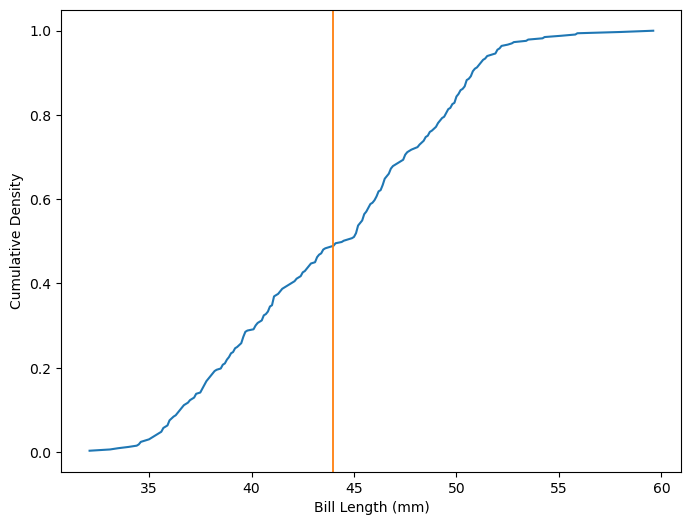

In [5]:
# Plot a cdf of the data
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(penguins_rv.xk, penguins_rv.cdf(penguins_rv.xk))
ax.axvline(penguins_rv.mean(), color='C1', lw=1.3) # mean, orange line

ax.set_xlabel('Bill Length (mm)')
ax.set_ylabel('Cumulative Density')

plt.show()

In [6]:
# Compute the cumulative probability density at a specific value and vice-versa
penguins_rv.cdf(40), penguins_rv.ppf(0.289)

(0.2882882882882882, 40.1)

## NormalCdfValues

NormalCdfValues is one of a number of functions that can be used to produce values for plotting models of various types of distributions using the parameters for the distrubutions. These functions are just thin wrappers on existing scipy stats methods. There are functions to produce cdf or pdf values to be plotted for the normal, pareto, and exponential distributions.

Plotting these models can help to see how closely data fits a particular distribution with particular parameters. As an example, let's look at how closely the distributions of bill lengths fits a normal distribution with the mean and standard deviation parameters obtained from the data.

In [7]:
xs, ps = dssv.NormalCdfValues(penguins_rv.mean(), penguins_rv.std(), n=101)

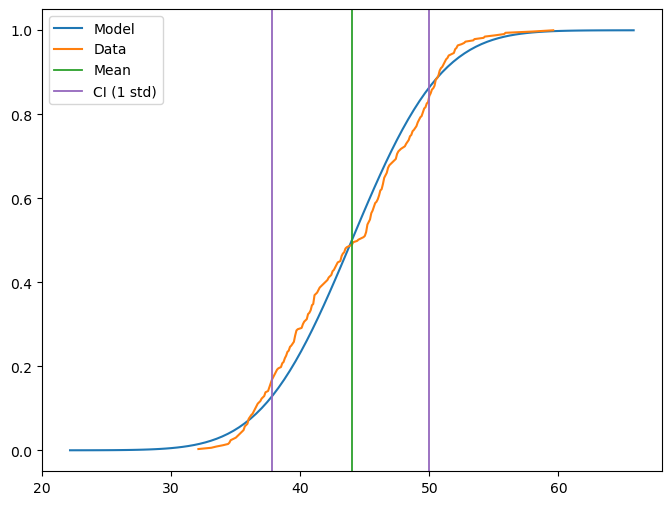

In [8]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(xs, ps, label='Model')
ax.plot(penguins_rv.xk, penguins_rv.cdf(penguins_rv.xk), label='Data')

# Add a line for the mean
ax.axvline(penguins_rv.mean(), color='C2', lw=1.3, label='Mean')

# Add lines for one standard deviation from the mean
ax.axvline(penguins_rv.interval(68/100)[0], color='C4', lw=1.3)
ax.axvline(penguins_rv.interval(68/100)[1], color='C4', lw=1.3, label='CI (1 std)')

ax.legend()

plt.show()

In this plot we can see significant deviations between the data and the model. This data also appears to be multimodal which indicates that we potentially have different groups within the data we need to look at separately.

We can use a seaborn catplot to look at different groups within the data.

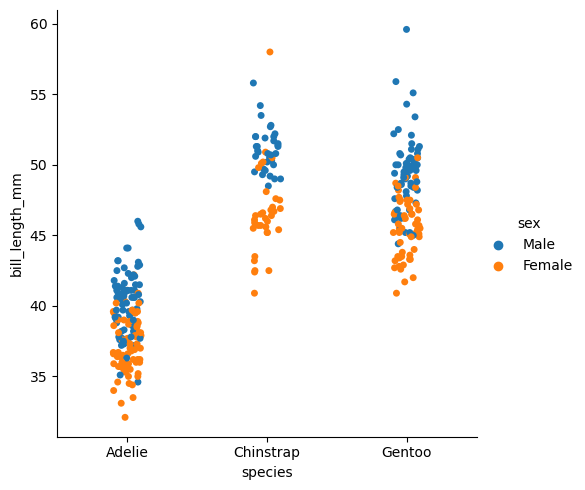

In [9]:
sns.catplot(x='species', y='bill_length_mm', hue='sex', data=df)

Let's try the same plot but looking at just the Adelie species of penguin.

In [10]:
adelie_bill_length = df[df.species == 'Adelie'].bill_length_mm
len(adelie_bill_length)

146

In [11]:
adelie_rv = dssv.DiscreteRv(adelie_bill_length)
print('Mean :', adelie_rv.mean())
print('Std :', adelie_rv.std())

Mean : 38.82397260273972
Std : 2.6534625813232458


In [12]:
xs, ps = dssv.NormalCdfValues(adelie_rv.mean(), adelie_rv.std(), n=101)

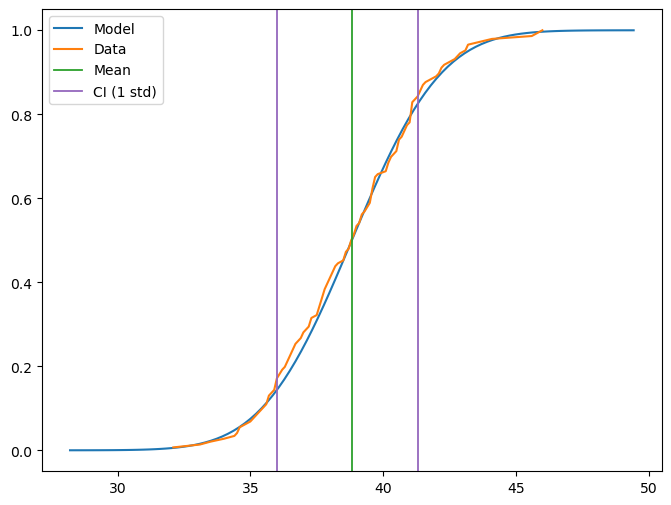

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(xs, ps, label='Model')
ax.plot(adelie_rv.xk, adelie_rv.cdf(adelie_rv.xk), label='Data')

# Add a line for the mean
ax.axvline(adelie_rv.mean(), color='C2', lw=1.3, label='Mean')

# Add lines for one standard deviation from the mean
ax.axvline(adelie_rv.interval(68/100)[0], color='C4', lw=1.3)
ax.axvline(adelie_rv.interval(68/100)[1], color='C4', lw=1.3, label='CI (1 std)')

ax.legend()

plt.show()

That's a much better fit. There are still some slight deviations from normal that could likely be explained by differences in bill length between male and female penguins.

## NormalProbabilityValues

Another way to visualize fit with a normal distribution is with a normal probability plot. The NormalProbabilityValues function produces the values to use to make this kind of plot.

There is also a function called NormProbPlot in the DataStats plotting module that uses this function to create one of these plots using a single function.

I'll demonstrate this using the same two examples as above: distribution of bill length for all penguins and then just for the Adelie species.

In [14]:
sorted_norm, sorted_data = dssv.NormalProbabilityValues(df.bill_length_mm)

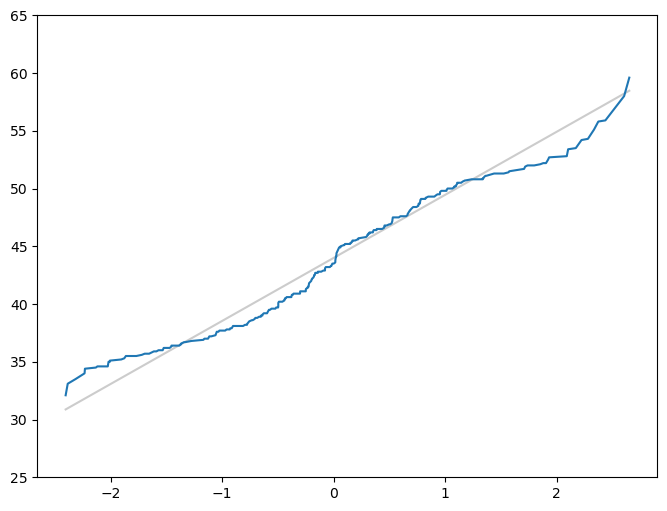

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Get the values to use to draw a fit line
fit_xs, fit_ys = FitLine([min(sorted_norm),max(sorted_norm)], penguins_rv.mean(), penguins_rv.std())

ax.plot(fit_xs, fit_ys, color='0.8')
ax.plot(sorted_norm, sorted_data)

ax.set_ylim(25,65)

plt.show()

In a normal probability plot, a straight line indicates that the data is normally distributed. This plot above is fairly close to linear, but it has a bit of an S-shape suggesting that it is in fact multimodal. Let's see if the line gets closer to linear if we create the same plot for just the Adelie species.

In [16]:
sorted_norm, sorted_data = dssv.NormalProbabilityValues(adelie_bill_length)

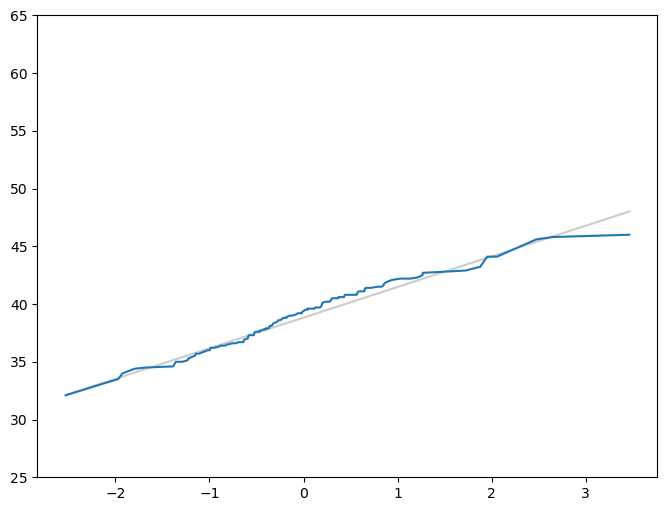

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Get the values to use to draw a fit line
fit_xs, fit_ys = FitLine([min(sorted_norm),max(sorted_norm)], adelie_rv.mean(), adelie_rv.std())

ax.plot(fit_xs, fit_ys, color='0.8')
ax.plot(sorted_norm, sorted_data)

ax.set_ylim(25,65)

plt.show()

That is very close to linear so we can confidently say that this data is normally distributed.

## RvPmfDiffs

The RvPmfDiffs function computes a shared range of values and the percentage point differences between the data for two different groups of a single discrete numerical variable. The resulting differences can then be plotted to show how the distributions of the two groups compare.  

In the example below I will make up some age data for two groups and then plot the pmf differences.

In [18]:
# Make age data with group1 being a bit higher
group1_ages = np.random.normal(41,2,size=200).astype(int)
group2_ages = np.random.normal(40,2,size=200).astype(int)

In [19]:
shared_xs, diffs = dssv.RvPmfDiffs(group1_ages, group2_ages)

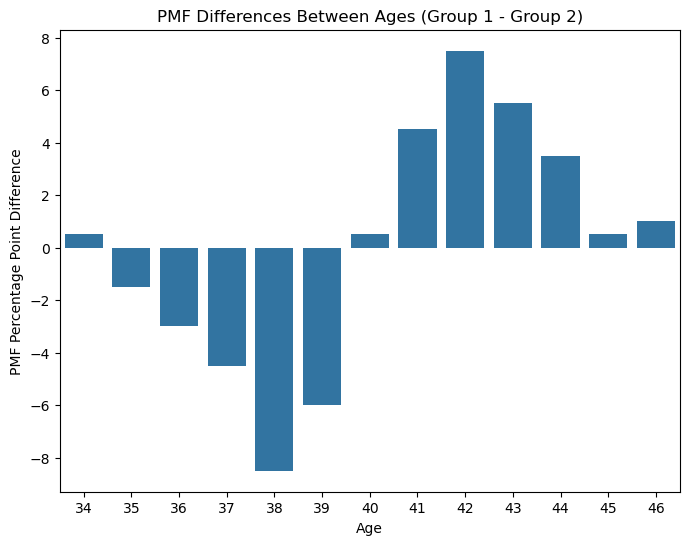

In [20]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

sns.barplot(x=shared_xs, y=diffs, ax=ax, color='C0')
ax.set_title('PMF Differences Between Ages (Group 1 - Group 2)')
ax.set_xlabel('Age')
ax.set_ylabel('PMF Percentage Point Difference')

plt.show()

Since Group 2 pmf values are subtracted from those of Group 1, in the above plot it can be seen that Group 1 has more people over the age of 40, and Group 2 has more people under the age of 40.

## SummarizeEstimates
SummarizeEstimates computes the mean, standard deviation (std error), and a confidence interval for a sampling distribution of supplied estimates (statistics produced by resampling).  
In this example I will use the data for bill length of adelie penguins from above.

In [21]:
adelie_bill_length

0      39.1
1      39.5
2      40.3
4      36.7
5      39.3
       ... 
147    36.6
148    36.0
149    37.8
150    36.0
151    41.5
Name: bill_length_mm, Length: 146, dtype: float64

First I'll build a sampling distribution of estimates for the mean bill length.

In [22]:
iters = 1000
mean_estimates = []

for _ in range(iters):
    sample = adelie_bill_length.sample(n=len(adelie_bill_length), replace=True)
    mean = sample.mean()
    mean_estimates.append(mean)

Then I'll use SummarizeEstimates to get the mean, standard error, and CI for the estimates (sampling distribution).

In [23]:
mean, std, CI = dssv.SummarizeEstimates(mean_estimates, conf_int=0.95)
mean, std, CI

(38.82848561643835, 0.2174583625957962, (38.39109589041095, 39.2554794520548))

## PValueFromEstimates
This function generates a pvalue from a sampling distribution (sequence of estimates) for a given test statistic.

In [24]:
dssv.PValueFromEstimates(mean_estimates, test_statistic=38.4, tail='left')

0.028000000000000018